In [1]:
import requests
import pandas as pd
%matplotlib inline

In [2]:
keytrans = {
    'id': 'serieid',
    'uom': 'serieunits',
    'station.properties.id': 'siteid',
    'station.properties.label': 'sitekey',
    'station.geometry.coordinates': 'geom',
    'firstValue.timestamp': 'start',
    'lastValue.timestamp': 'stop',
    #'parameters.feature.id': 'featureid',
    #'parameters.feature.label': 'featurekey',
    'parameters.phenomenon.id': 'measureid',
    'parameters.phenomenon.label': 'measurekey',
    #'parameters.category.id': 'categoryid',
    #'parameters.category.label': 'categorykey',
    #'statusIntervals': 'status'
}

In [3]:
def getMeta():
    # Download Timeserie Metadata:
    url = "https://geo.irceline.be/sos/api/v1/{target:}/?expanded=true"
    rep = requests.get(url.format(target='timeseries'))
    df = pd.io.json.json_normalize(rep.json())
    # Clean columns:
    df = df.loc[:,keytrans.keys()].rename(columns=keytrans)
    # Casts & postprocessing
    df['start'] = pd.to_datetime(df['start'], origin='unix', unit='ms')
    df['stop'] = pd.to_datetime(df['stop'], origin='unix', unit='ms')
    df['sitename'] = df['sitekey'].apply(lambda x: "-".join(x.split('-')[1:]))
    df['sitekey'] = df['sitekey'].apply(lambda x: x.split('-')[0].strip())
    df['lat'] = df['geom'].apply(lambda x: x[0])
    df['lon'] = df['geom'].apply(lambda x: x[1])
    return df.loc[:,['serieid', 'siteid', 'measureid', 'serieunits', 'measurekey', 'sitekey',
                     'sitename', 'lat', 'lon', 'start', 'stop']]

In [4]:
meta = getMeta()
meta.sample(5)

,serieid,siteid,measureid,serieunits,measurekey,sitekey,sitename,lat,lon,start,stop
159,10613,1711,38,µg/m³,Nitrogen monoxide,41B008,Brussel (Beliardstraat),4.376149,50.840789,2012-11-12 13:00:00,2020-03-10 15:00:00
28,6343,1073,391,µg/m³,Black Carbon,40SZ01,Steenokkerzeel,4.504183,50.914576,2012-05-31 01:00:00,2020-02-24 10:00:00
548,7072,1207,1,µg/m³,Sulphur dioxide,44R701,Gent,3.729298,51.058332,2012-05-31 01:00:00,2020-01-09 11:00:00
143,7097,1210,8,µg/m³,Nitrogen dioxide,44R721,Wondelgem,3.716119,51.088958,2011-01-01 01:00:00,2020-03-10 15:00:00
531,6864,1165,1,µg/m³,Sulphur dioxide,42R893,Antwerpen,4.385771,51.281378,2012-05-31 01:00:00,2020-03-10 15:00:00


In [5]:
def getData(series, start=None, stop=None):
    # Default Parameters:
    if isinstance(series, int):
        series = [series]
    elif isinstance(series, pd.DataFrame):
        series = list(series['serieid'])
    if stop is None:
        stop = pd.Timestamp.utcnow()
    if start is None:
        start = stop - pd.Timedelta("14 days")
    stop = pd.Timestamp(stop)
    start = pd.Timestamp(start)
    # Download Timeserie Data:
    dfs = []
    for sid in series:
        url = "https://geo.irceline.be/sos/api/v1/timeseries/{serieid:}/getData/?timespan={start:%Y-%m-%dT%H:%MZ}/{stop:%Y-%m-%dT%H:%MZ}&force_latest_values=true"
        rep = requests.get(url.format(serieid=sid, start=start, stop=stop))
        try:
            df = pd.DataFrame(rep.json()['values'])
            df['stop'] = pd.to_datetime(df['timestamp'], origin='unix', unit='ms')
            df['start'] = df['stop'] - pd.Timedelta('1H')
            df['serieid'] = sid
            df['value'] = df['value'].astype(float)
            dfs.append(df)
        except:
            pass
    if dfs:
        return pd.concat(dfs)

In [6]:
q1 = meta['sitekey'].str.startswith('41')
q2 = meta['measurekey'].isin(['Particulate Matter < 2.5 µm','relative humidity', 'temperature', 
                              'wind direction', 'wind speed (scalar)', 'Nitrogen dioxide'])
sel = meta.loc[q1&q2,:]
sel

,serieid,siteid,measureid,serieunits,measurekey,sitekey,sitename,lat,lon,start,stop
72,10614,1711,8,µg/m³,Nitrogen dioxide,41B008,Brussel (Beliardstraat),4.376149,50.840789,2012-11-12 13:00:00,2020-03-10 15:00:00
93,6504,1109,8,µg/m³,Nitrogen dioxide,41B001,Arts-Loi,4.368681,50.845715,2017-01-14 01:00:00,2020-03-10 15:00:00
94,6508,1110,8,µg/m³,Nitrogen dioxide,41B004,Bruxelles (Sainte-Catherine),4.348587,50.850811,2011-01-01 01:00:00,2020-03-10 15:00:00
95,6516,1112,8,µg/m³,Nitrogen dioxide,41B006,Bruxelles (Parlement UE),4.374388,50.838631,2011-01-01 01:00:00,2020-03-10 15:00:00
96,6528,1113,8,µg/m³,Nitrogen dioxide,41B011,Berchem-Sainte-Agathe,4.288336,50.858031,2011-01-01 01:00:00,2020-03-10 15:00:00
97,6551,1116,8,µg/m³,Nitrogen dioxide,41MEU1,Meudon,4.392718,50.895101,2011-09-23 12:00:00,2020-03-10 15:00:00
98,6561,1117,8,µg/m³,Nitrogen dioxide,41N043,Haren,4.382963,50.883560,2011-01-01 01:00:00,2020-03-10 15:00:00
99,6574,1118,8,µg/m³,Nitrogen dioxide,41R001,Molenbeek-Saint-Jean,4.333820,50.849665,2011-01-01 01:00:00,2020-03-10 15:00:00
100,6615,1119,8,µg/m³,Nitrogen dioxide,41R002,Ixelles,4.384719,50.825128,2011-01-01 01:00:00,2020-03-10 15:00:00
101,6622,1122,8,µg/m³,Nitrogen dioxide,41R012,Uccle,4.358539,50.796632,2011-01-01 01:00:00,2020-03-10 15:00:00


In [7]:
meta['measurekey'].unique()

array(['1,2-xylene O-xylene', 'Benzene', 'Black Carbon', 'Carbon Dioxide',
       'Carbon Monoxide', 'Elemental gaseous mercury', 'Ethylbenzene',
       'M+P-xylene', 'Nitrogen dioxide', 'Nitrogen monoxide', 'Ozone',
       'Particulate Matter < 1 µm', 'Particulate Matter < 10 µm',
       'Particulate Matter < 2.5 µm', 'relative humidity',
       'Sulphur dioxide', 'temperature', 'Toluene', 'wind direction',
       'wind speed (scalar)'], dtype=object)

In [8]:
recs = getData(sel, start='2020-02-10', stop='2020-03-10')
recs.sample(5)

,timestamp,value,stop,start,serieid
284,1582315200000,NaN,2020-02-21 20:00:00,2020-02-21 19:00:00,6574
378,1582653600000,4.35,2020-02-25 18:00:00,2020-02-25 17:00:00,6579
184,1581955200000,42.50,2020-02-17 16:00:00,2020-02-17 15:00:00,6504
548,1583265600000,51.00,2020-03-03 20:00:00,2020-03-03 19:00:00,6615
357,1582578000000,2.70,2020-02-24 21:00:00,2020-02-24 20:00:00,6564


In [9]:
data = recs.merge(sel.loc[:,['serieid', 'measurekey', 'sitekey', 'serieunits']])\
           .pivot_table(index='start', columns=['sitekey', 'measurekey', 'serieunits'], values='value')
data.sample(5)

sitekey                       41B001           41B004           41B006  \
measurekey          Nitrogen dioxide Nitrogen dioxide Nitrogen dioxide   
serieunits                     µg/m³            µg/m³            µg/m³   
start                                                                    
2020-02-26 15:00:00             59.0             27.0             32.5   
2020-02-26 08:00:00             50.0             32.5             43.5   
2020-03-05 13:00:00             45.5             31.0             37.5   
2020-02-15 21:00:00             20.5             11.0              NaN   
2020-02-15 14:00:00             31.0             14.0              NaN   

sitekey                       41B008           41B011  \
measurekey          Nitrogen dioxide Nitrogen dioxide   
serieunits                     µg/m³            µg/m³   
start                                                   
2020-02-26 15:00:00             69.0              9.5   
2020-02-26 08:00:00             71.0             11.5   
2020-03-05 13:00:00             69.0             30.0   
2020-02-15 21:00:00              NaN              0.5   
2020-02-15 14:00:00              NaN              8.5   

sitekey                                                   41MEU1  \
measurekey          Particulate Matter < 2.5 µm Nitrogen dioxide   
serieunits                                µg/m³            µg/m³   
start                                                              
2020-02-26 15:00:00                        2.85             15.0   
2020-02-26 08:00:00                        6.05             22.5   
2020-03-05 13:00:00                         NaN             31.5   
2020-02-15 21:00:00                        7.60              3.0   
2020-02-15 14:00:00                        6.80              7.0   

sitekey                       41N043                              \
measurekey          Nitrogen dioxide Particulate Matter < 2.5 µm   
serieunits                     µg/m³                       µg/m³   
start                                                              
2020-02-26 15:00:00             35.0                        3.80   
2020-02-26 08:00:00             37.5                        7.35   
2020-03-05 13:00:00             36.0                        4.00   
2020-02-15 21:00:00             10.5                       10.35   
2020-02-15 14:00:00             23.5                       10.40   

sitekey                       41R001  ...                             \
measurekey          Nitrogen dioxide  ... temperature wind direction   
serieunits                     µg/m³  ...           C        degrees   
start                                 ...                              
2020-02-26 15:00:00             29.0  ...        5.30          266.0   
2020-02-26 08:00:00             33.5  ...        2.35          232.0   
2020-03-05 13:00:00             36.0  ...        7.80           72.0   
2020-02-15 21:00:00              4.0  ...       12.30          190.0   
2020-02-15 14:00:00             11.5  ...       12.55          175.0   

sitekey                                           41R002           41R012  \
measurekey          wind speed (scalar) Nitrogen dioxide Nitrogen dioxide   
serieunits                          m/s            µg/m³            µg/m³   
start                                                                       
2020-02-26 15:00:00               4.345             41.0             15.0   
2020-02-26 08:00:00               4.040             39.0             14.0   
2020-03-05 13:00:00               4.730             27.0             15.0   
2020-02-15 21:00:00              10.935              9.0              1.0   
2020-02-15 14:00:00               6.490             19.5              3.0   

sitekey                                                            \
measurekey          Particulate Matter < 2.5 µm relative humidity   
serieunits                                µg/m³           percent   
start                                      

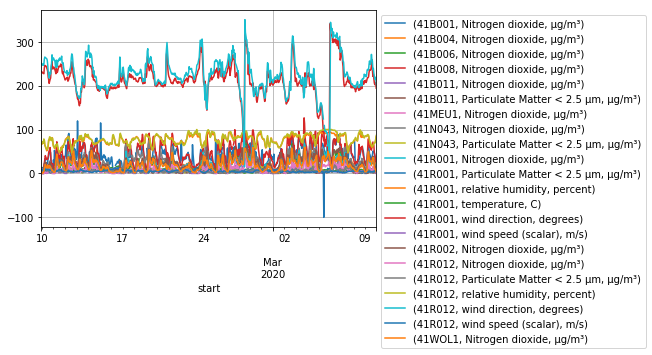

In [10]:
axe = data.plot()
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()

In [11]:
data.to_pickle("irceline.pickle")